In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import spacy
from heapq import nlargest
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

In [2]:
df = pd.read_csv('News3.csv')
df.head()

,Unnamed: 0,Title,Description,Body,Keywords,Theme,Link
0,1,Candy factory didn't evacuate concerned worker...,An eastern Pennsylvania candy factory didn’t e...,An eastern Pennsylvania candy factory didn’t e...,"accident investigations, accidents, accidents,...",us,https://edition.cnn.com/2023/10/06/us/pennsylv...
1,2,Baltimore police ask for public's help identif...,Two shooters were involved in an attack at Mor...,Two shooters were involved in an attack at Mor...,"baltimore, brand safety-nsf crime, brand safet...",us,https://edition.cnn.com/2023/10/06/us/morgan-s...
2,3,An arrest warrant has been issued for a suspec...,Authorities in Pennsylvania say they have issu...,Authorities in Pennsylvania say they have issu...,"arrest warrants, arrests, brand safety-nsf cri...",us,https://edition.cnn.com/2023/10/06/us/josh-kru...
3,4,115 improperly stored human remains found in C...,An investigation into more than 115 bodies fou...,An investigation into more than 115 bodies fou...,"brand safety-nsf death, brand safety-nsf sensi...",us,https://edition.cnn.com/2023/10/06/us/colorado...
4,5,Bronx day care provider and 2 others indicted ...,"A Bronx day care provider, her husband and his...","A Bronx day care provider, her husband and his...","brand safety-nsf crime, brand safety-nsf death...",us,https://edition.cnn.com/2023/10/05/us/bronx-da...


In [3]:
data = df.copy()

In [4]:
data = data[['Body', 'Theme']]
data.head()

,Body,Theme
0,An eastern Pennsylvania candy factory didn’t e...,us
1,Two shooters were involved in an attack at Mor...,us
2,Authorities in Pennsylvania say they have issu...,us
3,An investigation into more than 115 bodies fou...,us
4,"A Bronx day care provider, her husband and his...",us


In [5]:
data.shape

(3928, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    3928 non-null   object
 1   Theme   3928 non-null   object
dtypes: object(2)
memory usage: 61.5+ KB


In [7]:
data.isnull().sum()

Body     0
Theme    0
dtype: int64

In [8]:
data['Theme'].value_counts()

Theme
business         921
world            820
politics         565
health           480
us               317
opinions         280
sport            247
entertainment    144
weather          115
style             15
travel            13
cnn               11
Name: count, dtype: int64

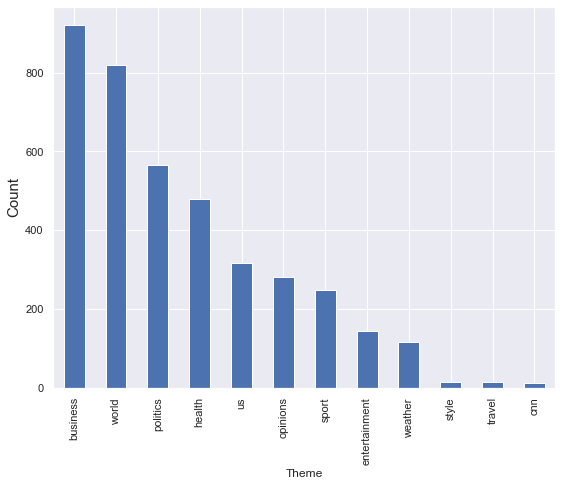

In [11]:
data['Theme'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.ylabel('Count', fontsize = 15)
plt.show()

In [14]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [17]:
nlp = spacy.load('en_core_web_sm')

In [55]:
def text_summarizing(text, num_sentences):
    doc = nlp(text)
    text = text.lower()
    text = re.sub('[^a-z.]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    words = [lemmatizer.lemmatize(word) for word in words]
    word_freq = Counter(words)
    word_freq_max = max(word_freq.values())
    for word, freq in word_freq.items():
        word_freq[word] = freq / word_freq_max
    sen_freq = dict()
    sentences = [sent.text for sent in doc.sents]
    for sen in sentences:
        for token in sen.split():
            if token in word_freq.keys():
                if sen not in sen_freq.keys():
                    sen_freq[sen] = word_freq[token]
                else:
                    sen_freq[sen] += word_freq[token]
    n = nlargest(num_sentences, sen_freq, key = sen_freq.get)
    p = []
    for i in sentences:
        for j in n:
            if i == j:
                p.append(i)
    return ' '.join(p)

In [56]:
data['Body'][0]

'An eastern Pennsylvania candy factory didn’t evacuate its employees – even as some said they smelled gas – before an explosion in March that left seven people dead and nearly a dozen others injured, the US Department of Labor announced.  R.M. Palmer, a Pennsylvania-based candy maker, was cited for failing to evacuate its workers during a natural gas leak, not having a clearly marked exit sign on one of its doors and for using spliced flexible cords at its West Reading manufacturing plant, according to a citation from the department’s Occupational Safety and Health Administration (OSHA). “Seven workers will never return home because the R.M. Palmer Co. did not evacuate the facility after being told of a suspected gas leak,” OSHA Area Director Kevin T. Chambers said in a Thursday news release. “Ensuring the safety of a workplace is expected of employers and required by law. The company could have prevented this horrific tragedy by following required safety procedures.”     The explosion

In [57]:
data['Body'][1]

'Two shooters were involved in an attack at Morgan State University in Baltimore outside a crowded homecoming event this week, injuring five people, authorities confirmed Friday. The Baltimore Police Department is asking for the public’s help in identifying four people seen walking near the scene of the Tuesday evening attack captured on video and still photos released by the agency on Friday. Anyone with information leading to an arrest and charges filed will receive a $9,000 reward, commissioner Richard Worley said during a Friday news conference. The victims – four men and one woman, ages 18 to 22 – were taken to a hospital with non-life-threatening injuries. Four are students, Morgan State University Police Chief Lance Hatcher said. As of Friday morning, four of the five victims have been released from the hospital and one remains hospitalized in stable condition, Worley said. The police department was able to confirm two shooters were involved in the incident from ballistic eviden

In [58]:
data['text_summarized'] = data['Body'].apply(lambda x: text_summarizing(x, num_sentences = 3))

In [59]:
data.head()

,Body,Theme,text_summarized
0,An eastern Pennsylvania candy factory didn’t e...,us,An eastern Pennsylvania candy factory didn’t e...
1,Two shooters were involved in an attack at Mor...,us,The nightmare unfolded as a popular homecoming...
2,Authorities in Pennsylvania say they have issu...,us,"The suspect is identified as Robert Davis, 19,..."
3,An investigation into more than 115 bodies fou...,us,An investigation into more than 115 bodies fou...
4,"A Bronx day care provider, her husband and his...",us,"A Bronx day care provider, her husband and his..."


In [60]:
data['Body'][0]

'An eastern Pennsylvania candy factory didn’t evacuate its employees – even as some said they smelled gas – before an explosion in March that left seven people dead and nearly a dozen others injured, the US Department of Labor announced.  R.M. Palmer, a Pennsylvania-based candy maker, was cited for failing to evacuate its workers during a natural gas leak, not having a clearly marked exit sign on one of its doors and for using spliced flexible cords at its West Reading manufacturing plant, according to a citation from the department’s Occupational Safety and Health Administration (OSHA). “Seven workers will never return home because the R.M. Palmer Co. did not evacuate the facility after being told of a suspected gas leak,” OSHA Area Director Kevin T. Chambers said in a Thursday news release. “Ensuring the safety of a workplace is expected of employers and required by law. The company could have prevented this horrific tragedy by following required safety procedures.”     The explosion

In [61]:
data['text_summarized'][0]

'An eastern Pennsylvania candy factory didn’t evacuate its employees – even as some said they smelled gas – before an explosion in March that left seven people dead and nearly a dozen others injured, the US Department of Labor announced.   R.M. Palmer, a Pennsylvania-based candy maker, was cited for failing to evacuate its workers during a natural gas leak, not having a clearly marked exit sign on one of its doors and for using spliced flexible cords at its West Reading manufacturing plant, according to a citation from the department’s Occupational Safety and Health Administration (OSHA). R.M. Palmer said while it is still mourning the deaths of its employees who died in the explosion, the company “does not agree that it has violated any provision of OSHA’s workplace standards” and believes OSHA’s statement about the citations was “inflammatory, callous, and irresponsible,” it said in two statements to CNN.'

In [62]:
data['Body'][1]

'Two shooters were involved in an attack at Morgan State University in Baltimore outside a crowded homecoming event this week, injuring five people, authorities confirmed Friday. The Baltimore Police Department is asking for the public’s help in identifying four people seen walking near the scene of the Tuesday evening attack captured on video and still photos released by the agency on Friday. Anyone with information leading to an arrest and charges filed will receive a $9,000 reward, commissioner Richard Worley said during a Friday news conference. The victims – four men and one woman, ages 18 to 22 – were taken to a hospital with non-life-threatening injuries. Four are students, Morgan State University Police Chief Lance Hatcher said. As of Friday morning, four of the five victims have been released from the hospital and one remains hospitalized in stable condition, Worley said. The police department was able to confirm two shooters were involved in the incident from ballistic eviden

In [63]:
data['text_summarized'][1]

'The nightmare unfolded as a popular homecoming week event was letting out – a violent disruption marking one of at least 531 mass shootings with at least four victims so far this year in the United States, according to the Gun Violence Archive, and one of at least 17 shootings this year at a US college or university, including in North Carolina, Oklahoma and Michigan. And all activities around homecoming will be either canceled or postponed – the first time in history the university has taken such action – until the suspects are found “and brought to justice,” Wilson said. “They were excited to hear from their university president and I pledged to them that this university will immediately provide one-on-one counseling to each of them,” he said.'

In [68]:
df_pol = data[data['Theme'] == 'politics']
df_wor = data[data['Theme'] == 'world'].sample(df_pol.shape[0])
df_bus = data[data['Theme'] == 'business'].sample(df_pol.shape[0])

In [69]:
df_balanced = pd.concat([df_pol, df_wor, df_bus])

In [70]:
df_balanced.head()

,Body,Theme,text_summarized
17,A New York appeals court judge on Friday rejec...,politics,Trump’s legal team believes the appellate cour...
18,President Joe Biden on Friday acknowledged he’...,politics,Biden this week used his White House appearanc...
19,Former House Speaker Kevin McCarthy is denying...,politics,Former House Speaker Kevin McCarthy is denying...
20,A former US Army sergeant who allegedly lived ...,politics,A former US Army sergeant who allegedly lived ...
87,Supreme Court Justice Samuel Alito on Friday f...,politics,Supreme Court Justice Samuel Alito on Friday f...


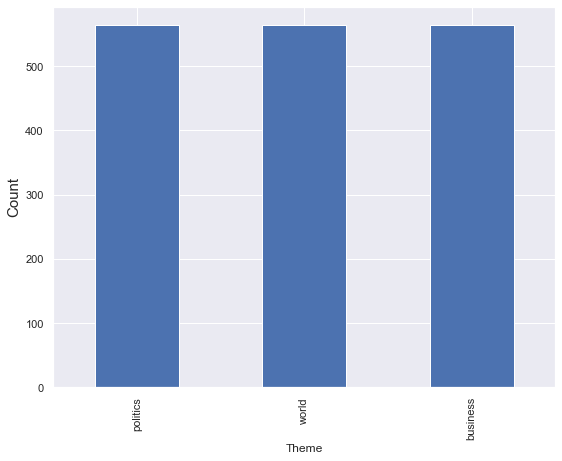

In [71]:
df_balanced['Theme'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.ylabel('Count', fontsize = 15)
plt.show()

In [72]:
df_balanced.shape

(1695, 3)

In [77]:
def text_cleaning(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [78]:
df_balanced['pre_text'] = df_balanced['text_summarized'].apply(text_cleaning)

In [79]:
df_balanced.head()

,Body,Theme,text_summarized,pre_text
17,A New York appeals court judge on Friday rejec...,politics,Trump’s legal team believes the appellate cour...,trump legal team belief appellate court could ...
18,President Joe Biden on Friday acknowledged he’...,politics,Biden this week used his White House appearanc...,biden week used white house appearance highlig...
19,Former House Speaker Kevin McCarthy is denying...,politics,Former House Speaker Kevin McCarthy is denying...,former house speaker kevin mccarthy denying re...
20,A former US Army sergeant who allegedly lived ...,politics,A former US Army sergeant who allegedly lived ...,former u army sergeant allegedly lived china s...
87,Supreme Court Justice Samuel Alito on Friday f...,politics,Supreme Court Justice Samuel Alito on Friday f...,supreme court justice samuel alito friday froz...


In [81]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_balanced['pre_text'])
seq = tokenizer.texts_to_sequences(df_balanced['pre_text'])

In [82]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

12654

In [83]:
maxlen = max([len(i) for i in seq])
maxlen

152

In [84]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [86]:
y = df_balanced['Theme']

In [88]:
le = LabelEncoder()
y_le = le.fit_transform(y)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y_le, test_size = 0.2, random_state = 101, shuffle = True, 
                                                   stratify = y_le)

In [90]:
X_train.shape

(1356, 152)

In [91]:
X_test.shape

(339, 152)

In [93]:
glove_file = open('glove.6B.100d.txt', encoding = 'utf-8')
embedding_matrix = dict()
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [94]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [97]:
classes = df_balanced['Theme'].nunique()
classes

3

In [116]:
model = Sequential()

In [117]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Conv1D(16, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(5)))
model.add(Dropout(0.4))
model.add(Dense(classes, activation = 'softmax'))

In [118]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [119]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [120]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3436 - loss: 1.1055 - val_accuracy: 0.6838 - val_loss: 1.0373
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5451 - loss: 1.0252 - val_accuracy: 0.7941 - val_loss: 0.9130
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6728 - loss: 0.9139 - val_accuracy: 0.8235 - val_loss: 0.7636
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7484 - loss: 0.7694 - val_accuracy: 0.8750 - val_loss: 0.5974
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8130 - loss: 0.6344 - val_accuracy: 0.8750 - val_loss: 0.5305
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8464 - loss: 0.5266 - val_accuracy: 0.8309 - val_loss: 0.5412
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8587 - loss: 0.4357 - val_accuracy: 0.8529 - val_loss: 0.4520
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8593 - loss: 0.4231 - val_accuracy: 0.

In [121]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8599 - loss: 0.4371


[0.3855167329311371, 0.8672566413879395]

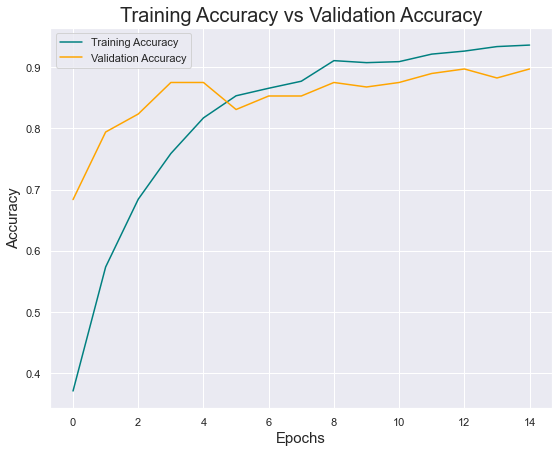

In [122]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.show()

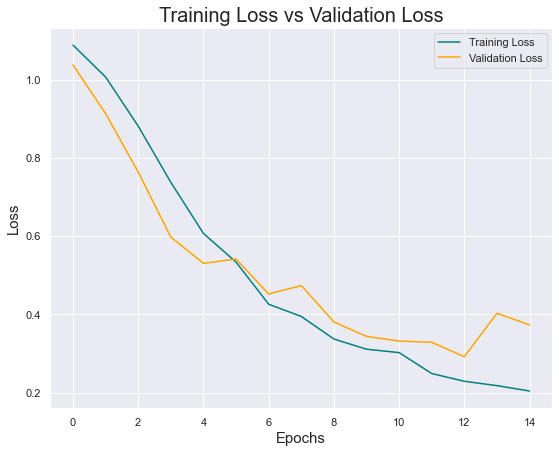

In [123]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.show()

In [124]:
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [127]:
y_p = [np.argmax(i) for i in y_pred]

In [129]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       113
           1       0.91      0.88      0.90       113
           2       0.83      0.85      0.84       113

    accuracy                           0.87       339
   macro avg       0.87      0.87      0.87       339
weighted avg       0.87      0.87      0.87       339



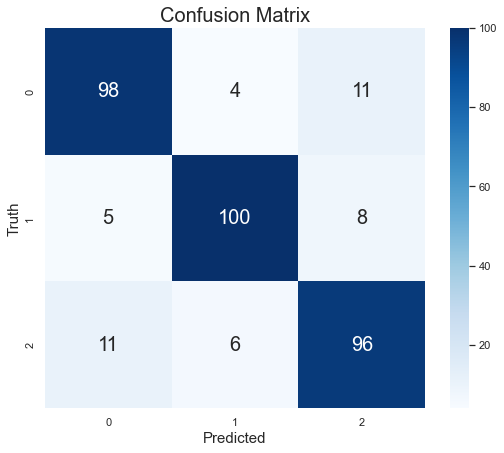

In [131]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_p), annot = True, square = True, cbar = True, annot_kws = {'size': 20}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 20)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Truth', fontsize = 15)
plt.show()